# SOLUTIONS: Analysis and Classification with Natural Language [Amazon Reviews Version]

In this notebook we will continue with the data we prepared in the last lecture.  Our goals will be to separate the data into high and low Ratings, compare and analyze them to notice any differences, and then to create a model to classify future Ratings as having a high or low sentiment.

In [1]:
from IPython.display import display, Markdown
with open("../Data-AmazonReviews/Amazon Product Reviews.md") as f:
    info = f.read()

display(Markdown(info))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

# Loading Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.probability import FreqDist
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', None)

# Import Processed Data

We created several versions of our text in the previous lecture.  We will load those again to use for analysis and classification

In [3]:
## Load processed data
# df = pd.read_csv('../Data/processed_data.csv')
df = pd.read_csv('../Data-AmazonReviews/processed_data.csv')
df.head()

,overall,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas
0,5.0,"I love it.: Carpets are clean and dry within one day. Depending on the weather, carpets may dry within an hour or two. Suction is amazing. I ran out of the Hoover cleaning solution mid-clean and substituted ""Kids n Pets"" cleaner with good results. No foaming, no shutdown, carpet just as clean as portion cleaned with Hoover solution. I recommend spot cleaning with the Hoover cleaning solution or with something like Kids N Pets a few minutes prior to shampooing, though test for fading first. Also recommend going slowly, about 8 seconds:1 foot ratio.\n\nPossible negatives: Lots of carpet fiber in receiving tank after cleaning. Hope it is not damaging carpet. Wish tanks were a bit larger to reduce number of water changes. Please note I have never used another steamvac to compare with.",789,"I love it.: Carpets are clean and dry within one day. Depending on the weather, carpets may dry within an hour or two. Suction is amazing. I ran out of the Hoover cleaning solution mid-clean and substituted ""Kids n Pets"" cleaner with good results. No foaming, no shutdown, carpet just as clean as portion cleaned with Hoover solution. I recommend spot cleaning with the Hoover cleaning solution or with something like Kids N Pets a few minutes prior to shampooing, though test for fading first. Also recommend going slowly, about 8 seconds:1 foot ratio.\n\nPossible negatives: Lots of carpet fiber in receiving tank after cleaning. Hope it is not damaging carpet. Wish tanks were a bit larger to reduce number of water changes. Please note I have never used another steamvac to compare with.","i love it.: carpets are clean and dry within one day. depending on the weather, carpets may dry within an hour or two. suction is amazing. i ran out of the hoover cleaning solution mid-clean and substituted ""kids n pets"" cleaner with good results. no foaming, no shutdown, carpet just as clean as portion cleaned with hoover solution. i recommend spot cleaning with the hoover cleaning solution or with something like kids n pets a few minutes prior to shampooing, though test for fading first. also recommend going slowly, about 8 seconds:1 foot ratio.\n\npossible negatives: lots of carpet fiber in receiving tank after cleaning. hope it is not damaging carpet. wish tanks were a bit larger to reduce number of water changes. please note i have never used another steamvac to compare with.","['i', 'love', 'it', '.', ':', 'carpets', 'are', 'clean', 'and', 'dry', 'within', 'one', 'day', '.', 'depending', 'on', 'the', 'weather', ',', 'carpets', 'may', 'dry', 'within', 'an', 'hour', 'or', 'two', '.', 'suction', 'is', 'amazing', '.', 'i', 'ran', 'out', 'of', 'the', 'hoover', 'cleaning', 'solution', 'mid-clean', 'and', 'substituted', '``', 'kids', 'n', 'pets', ""''"", 'cleaner', 'with', 'good', 'results', '.', 'no', 'foaming', ',', 'no', 'shutdown', ',', 'carpet', 'just', 'as', 'clean', 'as', 'portion', 'cleaned', 'with', 'hoover', 'solution', '.', 'i', 'recommend', 'spot', 'cleaning', 'with', 'the', 'hoover', 'cleaning', 'solution', 'or', 'with', 'something', 'like', 'kids', 'n', 'pets', 'a', 'few', 'minutes', 'prior', 'to', 'shampooing', ',', 'though', 'test', 'for', 'fading', 'first', '.', 'also', 'recommend', 'going', 'slowly', ',', 'about', '8', 'seconds:1', 'foot', 'ratio', '.', 'possible', 'negatives', ':', 'lots', 'of', 'carpet', 'fiber', 'in', 'receiving', 'tank', 'after', 'cleaning', '.', 'hope', 'it', 'is', 'not', 'damaging', 'carpet', '.', 'wish', 'tanks', 'were', 'a', 'bit', 'larger', 'to', 'reduce', 'number', 'of', 'water', 'changes', '.', 'please', 'note', 'i', 'have', 'never', 'used', 'another', 'steamvac', 'to', 'compare', 'with', '.']","['love', '.', ':', 'carpets', 'clean', 'dry', 'within', 'one', 'day', '.', 'depending', 'weather', ',', 'carpets', 'may', 'dry', 'within', 'hour', 'two', '.', 'suction', 'amazing', '.', 'ran', 'hoover', 'cleaning', 'solution', 'mid

In [4]:
df.isna().sum()

overall              0
text-raw             0
length               0
text                 0
lower_text           0
tokens               0
no_stops             0
no_stops_no_punct    0
spacy_lemmas         0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8191 entries, 0 to 8190
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   overall            8191 non-null   float64
 1   text-raw           8191 non-null   object 
 2   length             8191 non-null   int64  
 3   text               8191 non-null   object 
 4   lower_text         8191 non-null   object 
 5   tokens             8191 non-null   object 
 6   no_stops           8191 non-null   object 
 7   no_stops_no_punct  8191 non-null   object 
 8   spacy_lemmas       8191 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 576.1+ KB


In [6]:

test_lemmas = df.loc[0,'spacy_lemmas']
test_lemmas

"['love', 'carpet', 'clean', 'dry', 'day', 'depend', 'weather', 'carpet', 'dry', 'hour', 'suction', 'amazing', 'run', 'hoover', 'cleaning', 'solution', 'mid', 'clean', 'substituted', 'kids', 'n', 'pets', 'clean', 'good', 'result', 'foaming', 'shutdown', 'carpet', 'clean', 'portion', 'clean', 'hoover', 'solution', 'recommend', 'spot', 'clean', 'hoover', 'cleaning', 'solution', 'like', 'kids', 'n', 'pets', 'minute', 'prior', 'shampoo', 'test', 'fade', 'recommend', 'go', 'slowly', '8', 'seconds:1', 'foot', 'ratio', 'possible', 'negative', 'lot', 'carpet', 'fiber', 'receive', 'tank', 'clean', 'hope', 'damage', 'carpet', 'wish', 'tank', 'bit', 'large', 'reduce', 'number', 'water', 'change', 'note', 'steamvac', 'compare']"

In [7]:
## Check type of first row
type(test_lemmas)

str

## Convert strings of lists to lists

You might recall that pandas interprets lists and strings when importing data.  We can define a quick function to convert them back.

How can we use string methods to do this?

In [8]:
## Function to convert string lists back to lists

def convert_to_list(string):
    """Remove braces, split tokens on commas, and then strip quotes from outside of each token"""
    new_list = [token.strip("' ") for token in string.strip("[]").split(',')]
    return new_list

In [9]:
## applymap function to convert string lists back to lists.

cols = ['tokens','no_stops','no_stops_no_punct','spacy_lemmas'] #, 'bigrams']
df[cols] = df[cols].applymap(convert_to_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8191 entries, 0 to 8190
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   overall            8191 non-null   float64
 1   text-raw           8191 non-null   object 
 2   length             8191 non-null   int64  
 3   text               8191 non-null   object 
 4   lower_text         8191 non-null   object 
 5   tokens             8191 non-null   object 
 6   no_stops           8191 non-null   object 
 7   no_stops_no_punct  8191 non-null   object 
 8   spacy_lemmas       8191 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 576.1+ KB


In [10]:
type(df.loc[0,'spacy_lemmas'])

list

Alternatively, the saved joblib file version does not need any additional preprocessing, the lists are still lists.

In [11]:
import joblib
df = joblib.load('../Data-AmazonReviews/processed_data.joblib')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8191 entries, 0 to 8256
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   overall            8191 non-null   float64
 1   text-raw           8191 non-null   object 
 2   length             8191 non-null   int64  
 3   text               8191 non-null   object 
 4   lower_text         8191 non-null   object 
 5   tokens             8191 non-null   object 
 6   no_stops           8191 non-null   object 
 7   no_stops_no_punct  8191 non-null   object 
 8   spacy_lemmas       8191 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 639.9+ KB


,overall,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas
0,5.0,"I love it.: Carpets are clean and dry within one day. Depending on the weather, carpets may dry within an hour or two. Suction is amazing. I ran out of the Hoover cleaning solution mid-clean and substituted ""Kids n Pets"" cleaner with good results. No foaming, no shutdown, carpet just as clean as portion cleaned with Hoover solution. I recommend spot cleaning with the Hoover cleaning solution or with something like Kids N Pets a few minutes prior to shampooing, though test for fading first. Also recommend going slowly, about 8 seconds:1 foot ratio.\n\nPossible negatives: Lots of carpet fiber in receiving tank after cleaning. Hope it is not damaging carpet. Wish tanks were a bit larger to reduce number of water changes. Please note I have never used another steamvac to compare with.",789,"I love it.: Carpets are clean and dry within one day. Depending on the weather, carpets may dry within an hour or two. Suction is amazing. I ran out of the Hoover cleaning solution mid-clean and substituted ""Kids n Pets"" cleaner with good results. No foaming, no shutdown, carpet just as clean as portion cleaned with Hoover solution. I recommend spot cleaning with the Hoover cleaning solution or with something like Kids N Pets a few minutes prior to shampooing, though test for fading first. Also recommend going slowly, about 8 seconds:1 foot ratio.\n\nPossible negatives: Lots of carpet fiber in receiving tank after cleaning. Hope it is not damaging carpet. Wish tanks were a bit larger to reduce number of water changes. Please note I have never used another steamvac to compare with.","i love it.: carpets are clean and dry within one day. depending on the weather, carpets may dry within an hour or two. suction is amazing. i ran out of the hoover cleaning solution mid-clean and substituted ""kids n pets"" cleaner with good results. no foaming, no shutdown, carpet just as clean as portion cleaned with hoover solution. i recommend spot cleaning with the hoover cleaning solution or with something like kids n pets a few minutes prior to shampooing, though test for fading first. also recommend going slowly, about 8 seconds:1 foot ratio.\n\npossible negatives: lots of carpet fiber in receiving tank after cleaning. hope it is not damaging carpet. wish tanks were a bit larger to reduce number of water changes. please note i have never used another steamvac to compare with.","[i, love, it, ., :, carpets, are, clean, and, dry, within, one, day, ., depending, on, the, weather, ,, carpets, may, dry, within, an, hour, or, two, ., suction, is, amazing, ., i, ran, out, of, the, hoover, cleaning, solution, mid-clean, and, substituted, ``, kids, n, pets, '', cleaner, with, good, results, ., no, foaming, ,, no, shutdown, ,, carpet, just, as, clean, as, portion, cleaned, with, hoover, solution, ., i, recommend, spot, cleaning, with, the, hoover, cleaning, solution, or, with, something, like, kids, n, pets, a, few, minutes, prior, to, shampooing, ,, though, test, for, fading, first, ., also, ...]","[love, ., :, carpets, clean, dry, within, one, day, ., depending, weather, ,, carpets, may, dry, within, hour, two, ., suction, amazing, ., ran, hoover, cleaning, solution, mid-clean, substituted, ``, kids, n, pets, '', cleaner, good, results, ., foaming, ,, shutdown, ,, carpet, clean, portion, cleaned, hoover, solution, ., recommend, spot, cleaning, hoover, cleaning, solution, something, like, kids, n, pets, minutes, prior, shampooing, ,, though, test, fading, first, ., also, recommend, going, slowly, ,, 8, seconds:1, foot, ratio, ., possible, negatives, :, lots, carpet, fiber, receiving, tank, cleaning, ., hope, damaging, carpet, ., wish, tanks, bit, larger, reduce, number, water, ...]","[love, carpets, clean, dry, within, one, day, depending, weather, carpets, may, dry, within, hour, two, suction, amazing, ran, hoover, cleaning, solution, mid-clean, substituted, ``, kids, n

In [12]:
type(df.loc[0, 'spacy_lemmas'])

list

# Class Balance

It's always a good idea to check the class balance when creating a classification model.  This can affect modeling bias and interpretation of metrics.

In [13]:
df['overall'].value_counts()

5.0    5547
4.0    1395
1.0     531
3.0     437
2.0     281
Name: overall, dtype: int64

In [51]:
def create_target(x):
    if x>=5.0:
        return "high"
    elif x <=2.0:
        return "low"
    else: 
        return None
    

In [52]:
# ## Çreate a binary high/low review column
# target_map = {1.0:'low',
#              2.0:'low',
#               # 3.0:'mid',
#               # 4.0:'high',
#              5.0:'high'}
df['rating'] = df['overall'].map(create_target)
df['rating'].value_counts(dropna=False)

high    5547
None    1832
low      812
Name: rating, dtype: int64

In [15]:
df['rating'].value_counts(normalize=True)

high    0.872307
low     0.127693
Name: rating, dtype: float64

There are more neutral Ratings any any other class, but high and low Ratings are pretty balanced.

# Divide by Rating

Since we want to compare and classify high vs low Ratings, we will create 2 different datasets: One of high Ratings and one of low Ratings.  We will not use the neutral Ratings for this lecture.

In [16]:
## Divide documents by sentiment
high = df.loc[df['rating'] == 'high']
low = df.loc[df['rating'] == 'low']
print('high Ratings')
display(high.head())
print('low Ratings')
display(low.head())

high Ratings


,overall,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,rating
0,5.0,"I love it.: Carpets are clean and dry within one day. Depending on the weather, carpets may dry within an hour or two. Suction is amazing. I ran out of the Hoover cleaning solution mid-clean and substituted ""Kids n Pets"" cleaner with good results. No foaming, no shutdown, carpet just as clean as portion cleaned with Hoover solution. I recommend spot cleaning with the Hoover cleaning solution or with something like Kids N Pets a few minutes prior to shampooing, though test for fading first. Also recommend going slowly, about 8 seconds:1 foot ratio.\n\nPossible negatives: Lots of carpet fiber in receiving tank after cleaning. Hope it is not damaging carpet. Wish tanks were a bit larger to reduce number of water changes. Please note I have never used another steamvac to compare with.",789,"I love it.: Carpets are clean and dry within one day. Depending on the weather, carpets may dry within an hour or two. Suction is amazing. I ran out of the Hoover cleaning solution mid-clean and substituted ""Kids n Pets"" cleaner with good results. No foaming, no shutdown, carpet just as clean as portion cleaned with Hoover solution. I recommend spot cleaning with the Hoover cleaning solution or with something like Kids N Pets a few minutes prior to shampooing, though test for fading first. Also recommend going slowly, about 8 seconds:1 foot ratio.\n\nPossible negatives: Lots of carpet fiber in receiving tank after cleaning. Hope it is not damaging carpet. Wish tanks were a bit larger to reduce number of water changes. Please note I have never used another steamvac to compare with.","i love it.: carpets are clean and dry within one day. depending on the weather, carpets may dry within an hour or two. suction is amazing. i ran out of the hoover cleaning solution mid-clean and substituted ""kids n pets"" cleaner with good results. no foaming, no shutdown, carpet just as clean as portion cleaned with hoover solution. i recommend spot cleaning with the hoover cleaning solution or with something like kids n pets a few minutes prior to shampooing, though test for fading first. also recommend going slowly, about 8 seconds:1 foot ratio.\n\npossible negatives: lots of carpet fiber in receiving tank after cleaning. hope it is not damaging carpet. wish tanks were a bit larger to reduce number of water changes. please note i have never used another steamvac to compare with.","[i, love, it, ., :, carpets, are, clean, and, dry, within, one, day, ., depending, on, the, weather, ,, carpets, may, dry, within, an, hour, or, two, ., suction, is, amazing, ., i, ran, out, of, the, hoover, cleaning, solution, mid-clean, and, substituted, ``, kids, n, pets, '', cleaner, with, good, results, ., no, foaming, ,, no, shutdown, ,, carpet, just, as, clean, as, portion, cleaned, with, hoover, solution, ., i, recommend, spot, cleaning, with, the, hoover, cleaning, solution, or, with, something, like, kids, n, pets, a, few, minutes, prior, to, shampooing, ,, though, test, for, fading, first, ., also, ...]","[love, ., :, carpets, clean, dry, within, one, day, ., depending, weather, ,, carpets, may, dry, within, hour, two, ., suction, amazing, ., ran, hoover, cleaning, solution, mid-clean, substituted, ``, kids, n, pets, '', cleaner, good, results, ., foaming, ,, shutdown, ,, carpet, clean, portion, cleaned, hoover, solution, ., recommend, spot, cleaning, hoover, cleaning, solution, something, like, kids, n, pets, minutes, prior, shampooing, ,, though, test, fading, first, ., also, recommend, going, slowly, ,, 8, seconds:1, foot, ratio, ., possible, negatives, :, lots, carpet, fiber, receiving, tank, cleaning, ., hope, damaging, carpet, ., wish, tanks, bit, larger, reduce, number, water, ...]","[love, carpets, clean, dry, within, one, day, depending, weather, carpets, may, dry, within, hour, two, suction, amazing, ran, hoover, cleaning, solution, mid-clean, substituted, ``, 

low Ratings


,overall,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,rating
14,1.0,"WORST THING I HAVE EVER USED!!!: This cleaner is both extremely difficult to setup and to use. First you have to put it together which is extremely hard because the directions make no sense. Next when you are trying to use it the directions are also extremely hard to follow. It is by far the worst thing I have ever used. Do not buy this product, you will regret it.",367,"WORST THING I HAVE EVER USED!!!: This cleaner is both extremely difficult to setup and to use. First you have to put it together which is extremely hard because the directions make no sense. Next when you are trying to use it the directions are also extremely hard to follow. It is by far the worst thing I have ever used. Do not buy this product, you will regret it.","worst thing i have ever used!!!: this cleaner is both extremely difficult to setup and to use. first you have to put it together which is extremely hard because the directions make no sense. next when you are trying to use it the directions are also extremely hard to follow. it is by far the worst thing i have ever used. do not buy this product, you will regret it.","[worst, thing, i, have, ever, used, !, !, !, :, this, cleaner, is, both, extremely, difficult, to, setup, and, to, use, ., first, you, have, to, put, it, together, which, is, extremely, hard, because, the, directions, make, no, sense, ., next, when, you, are, trying, to, use, it, the, directions, are, also, extremely, hard, to, follow, ., it, is, by, far, the, worst, thing, i, have, ever, used, ., do, not, buy, this, product, ,, you, will, regret, it, .]","[worst, thing, ever, used, !, !, !, :, cleaner, extremely, difficult, setup, use, ., first, put, together, extremely, hard, directions, make, sense, ., next, trying, use, directions, also, extremely, hard, follow, ., far, worst, thing, ever, used, ., buy, product, ,, regret, .]","[worst, thing, ever, used, cleaner, extremely, difficult, setup, use, first, put, together, extremely, hard, directions, make, sense, next, trying, use, directions, also, extremely, hard, follow, far, worst, thing, ever, used, buy, product, regret]","[bad, thing, cleaner, extremely, difficult, setup, use, extremely, hard, direction, sense, try, use, direction, extremely, hard, follow, far, bad, thing, buy, product, regret]",low
16,1.0,"So disappointed!: At first I thought it was great, it does a wonderful job on carpets. Half the reason I bought it, however, is so I could clean my couches.\n\n All I have been able to get it to do it dribble/pour out water when I use the upholstery tool. It is supposed to spray it evenly. I have read and re-read the manual and searched for a solution online and come up short handed. I bought the insurance and am hoping that will help. This thing may just have to go back If the issue can't be resolved. Hoover used to be a quality company, but it seems they just make cheap crap and cut corners like everyone else now :(",623,"So disappointed!: At first I thought it was great, it does a wonderful job on carpets. Half the reason I bought it, however, is so I could clean my couches.\n\n All I have been able to get it to do it dribble/pour out water when I use the upholstery tool. It is supposed to spray it evenly. I have read and re-read the manual and searched for a solution online and come up short handed. I bought the insurance and am hoping that will help. This thing may just have to go back If the issue can't be resolved. Hoover used to be a quality company, but it seems they just make cheap crap and cut corners like everyone else now :(","so disappointed!: at first i thought it was great, it does a wonderful job on carpets. half the reason i bought it, however, is so i could clean my couches.\n\n all i have been able to get it to do it dribble/pour out water when i use the upholstery tool. it is supposed to spray it evenly. i have read and re-read the manual and searched fo

# Length

One easy way to compare text is to compare the length of each text.  We could compare the number of character or tokens.  In this case we will compare the number of characters in each Rating for each sentiment.

The median high Rating is 254.0 characters long while the median low Rating is 421.0 long


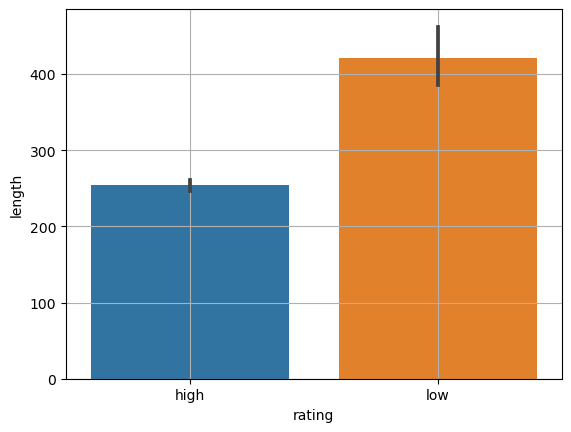

In [17]:
## visualize median Rating length
pos_len = high['length'].median()
neg_len = low['length'].median()

print(f'The median high Rating is {pos_len} characters long while the median low Rating is {neg_len} long')
sns.barplot(data=df, x='rating', y='length', estimator='median')
plt.grid()

We aren't seeing a big difference here in the lengths of Ratings.  Both high and low seem to averag about 70 characters.  Neutral Ratings seem to be somewhat shorter on average.

# Frequency Distribution

Let's take a look at how often different words appear in the Ratings.  

The NLTK FreqDist class expects a list of all tokens in all documents.  We can create this with the `.explode()` method to create new rows for every word.  We can then convert the resulting series to a list with `to_list()` to pass to the `FreqDist` class constructor.

In [18]:
## Create list of all tokens in all documents
pos_words = high['tokens'].explode().to_list()
neg_words = low['tokens'].explode().to_list()
pos_words[:10]

['i', 'love', 'it', '.', ':', 'carpets', 'are', 'clean', 'and', 'dry']

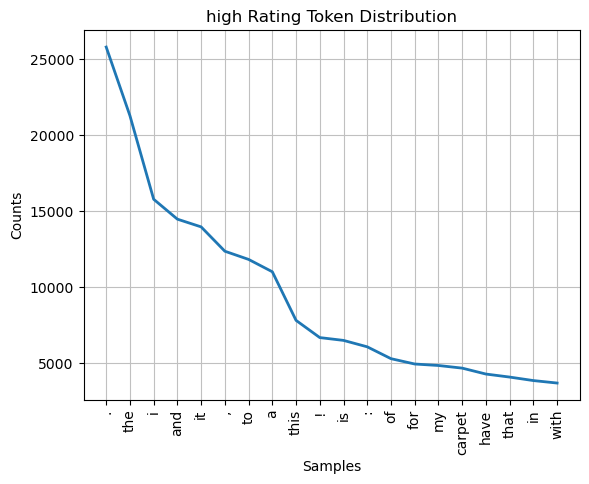

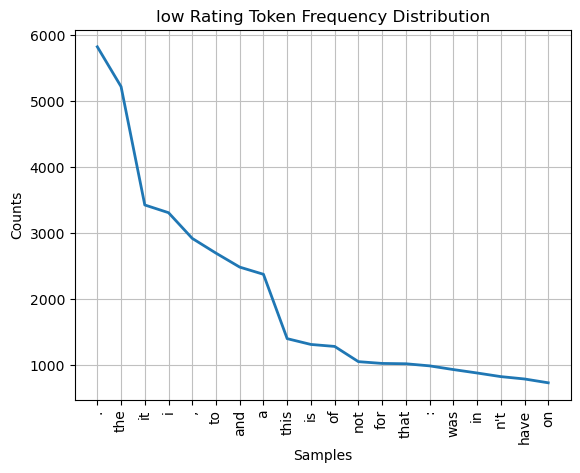

In [19]:
## Instantiate high frequency distribution
pos_freq_dist = FreqDist(pos_words)
neg_freq_dist = FreqDist(neg_words)

## Plot the distribution
pos_freq_dist.plot(20, title='high Rating Token Distribution')

neg_freq_dist.plot(20, title='low Rating Token Frequency Distribution');

We can see already that punctuation and very common words are at the top of both lists.  To avoid this, we can use our normalized data instead.  Let's use our lemmas!

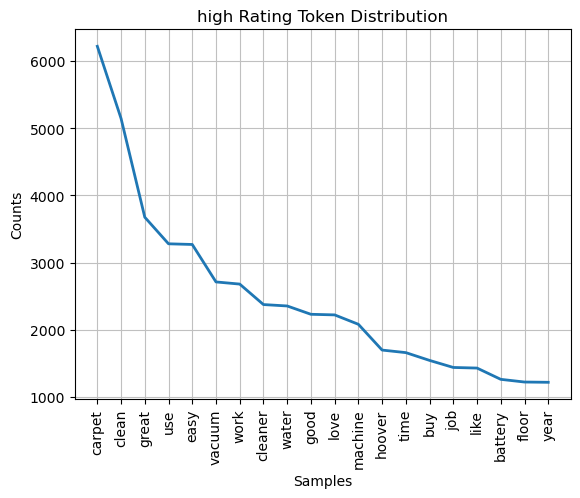

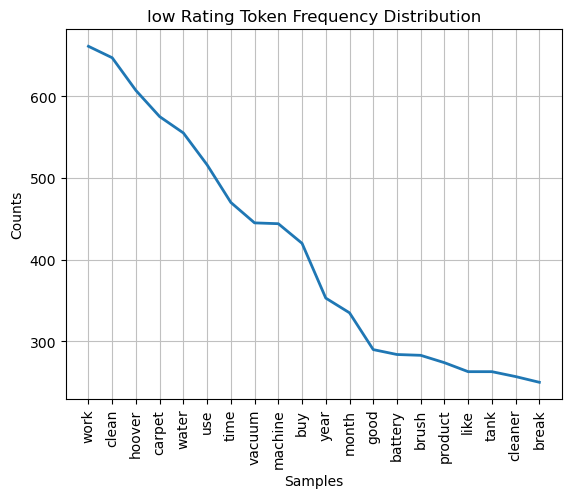

In [20]:
## Create list of all tokens in all documents
pos_words = high['spacy_lemmas'].explode().to_list()
neg_words = low['spacy_lemmas'].explode().to_list()

## Instantiate high frequency distribution
pos_freq_dist = FreqDist(pos_words)
neg_freq_dist = FreqDist(neg_words)

## Plot the distribution
pos_freq_dist.plot(20, title='high Rating Token Distribution')

neg_freq_dist.plot(20, title='low Rating Token Frequency Distribution');

These are more informative!  We see words like 'good', 'love', 'hope', 'great', and 'nice' in the highs and 'miss', 'work', 'sad', 'bad', and 'hate' in lows.

While this may not be surprising with high and low sentiments, if we were classifying other kinds of text, like spam emails or patent applications, it could be very enlightening!

# Word Clouds

Word Clouds tell us the same kinds of things as a frequency distribution, but are a nice way to visualize.  They can be used for project headers or presentations.

The `WordCloud` class expects texts to be one long string, so.  We will use our lemmas again, so we have to join all the tokens for each document into one long string.

## Processing the data for WordCloud

WordCloud expects one single string of all the words in a corpus.  since we already have a list of all the words, for each sentiment, we can just join those.

In [21]:
## Join the words for each sentiment
all_pos_lemmas = ' '.join(pos_words)
all_neg_lemmas = ' '.join(neg_words)
type(all_pos_lemmas)

str

## Creating and displaying the Word Clouds

We will create the clouds and generate the images below.  We want to focus on larger words, otherwise we get some strange results due to contractions.  We will tell WordCloud to only generate words with 2 or more letters.

(-0.5, 599.5, 399.5, -0.5)

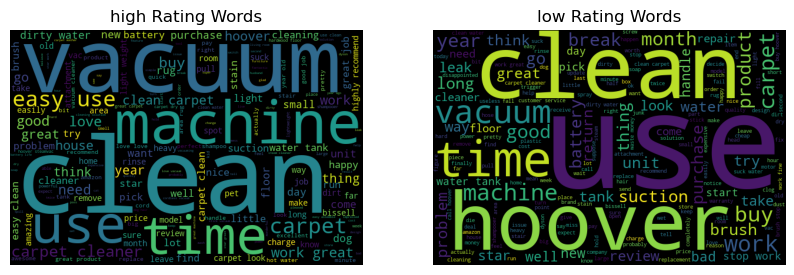

In [22]:
## Generate the WordCloud Images
pos_cloud = WordCloud(min_word_length=2,width=600, height=400).generate(all_pos_lemmas)
neg_cloud = WordCloud(min_word_length=2,width=600, height=400).generate(all_neg_lemmas)

## Plot the Images

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(pos_cloud)
axes[0].set_title('high Rating Words')
axes[0].axis('off')

axes[1].imshow(neg_cloud)
axes[1].set_title('low Rating Words')
axes[1].axis('off')


This can be a fun way to help you stakeholders get a feel for the token distributions in our data.

# N-gram Analysis

We can do something similar with ngrams.  NLTK has native classes for finding and measuring the frequency of ngrams as well.

For this we need 2 objects: a measures class depending on the measure we want to see and a finder class based on the number of words in our ngram.

These classes exist for bi, tri, and quadgrams, but we will just focus on bigrams.

## Calcuate Frequency Scores

In [23]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

## Create measure classes
measures = BigramAssocMeasures()

## Create collector classes
pos_finder = BigramCollocationFinder.from_words(pos_words)
neg_finder = BigramCollocationFinder.from_words(neg_words)

In [24]:
## Calculate high and low ngram scores
pos_scores = pos_finder.score_ngrams(measures.raw_freq)
pos_ngram_scores = pd.DataFrame(pos_scores, columns=['high ngram', 'high score'])

neg_scores = neg_finder.score_ngrams(measures.raw_freq)
neg_ngram_scores = pd.DataFrame(neg_scores, columns=['low ngram', 'low score'])

## Display the frequency scores
display(pos_ngram_scores.head(20))
display(neg_ngram_scores.head(20))

,high ngram,high score
0,"(easy, use)",0.006112
1,"(carpet, cleaner)",0.005889
2,"(work, great)",0.004433
3,"(clean, carpet)",0.003311
4,"(dirty, water)",0.002786
5,"(carpet, clean)",0.002084
6,"(great, job)",0.002043
7,"(easy, clean)",0.001965
8,"(carpet, look)",0.001741
9,"(highly, recommend)",0.001731


,low ngram,low score
0,"(stop, work)",0.002689
1,"(water, tank)",0.002641
2,"(carpet, cleaner)",0.002519
3,"(dirty, water)",0.002350
4,"(customer, service)",0.002205
5,"(clean, carpet)",0.001914
6,"(work, great)",0.001793
7,"(clean, water)",0.001308
8,"(6, month)",0.001163
9,"(waste, money)",0.001114


## Plot Frequency Scores

<Axes: title={'center': 'low Ngram Frequency'}, xlabel='low ngram'>

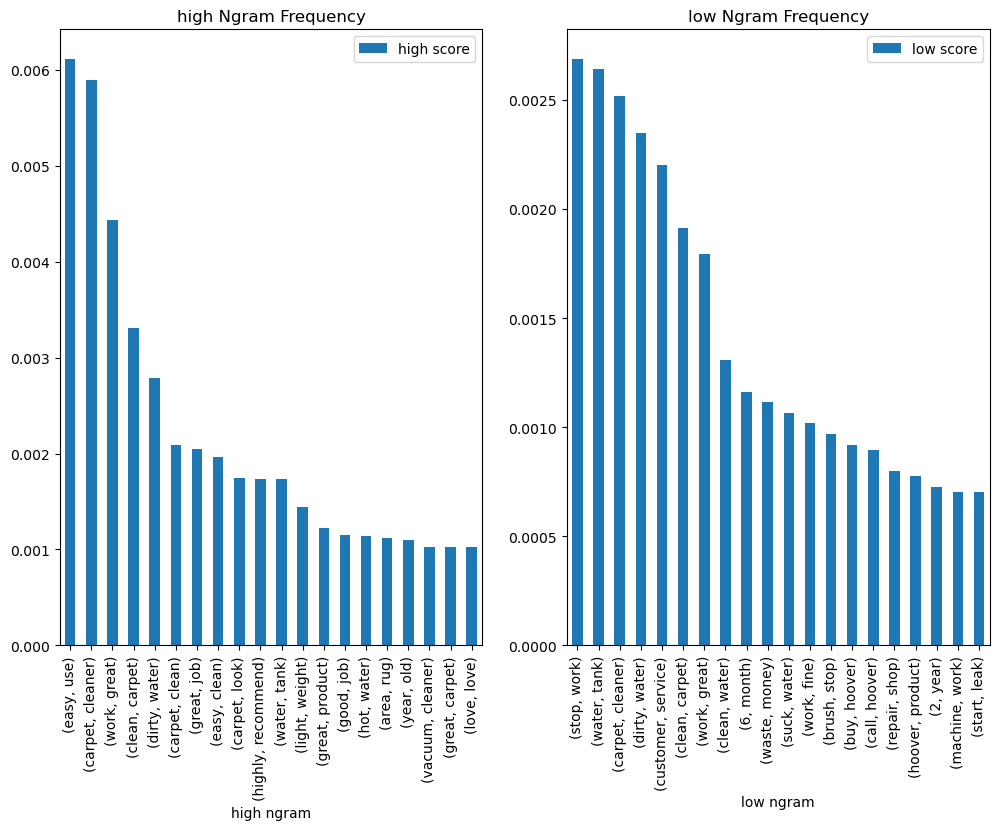

In [25]:
## Create a figure and axes
fig, axes = plt.subplots(1,2, figsize=(12,8))

## Plot the ngram frequencies
pos_ngram_scores.head(20).plot(x='high ngram', kind='bar', title='high Ngram Frequency',
                                        ax=axes[0])
neg_ngram_scores.head(20).plot(x='low ngram', kind='bar', title='low Ngram Frequency',
                                        ax=axes[1])

This might be more enlightening than the individual word frequency counts.  There are some relatable bigrams here.

We are also seeing a lot of versions of 'happy mother's day' which may tell us that more normalization is required here.  This would be a consideration in longer term projects.

### Trigrams

In [26]:
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder

## Create measure classes
measures = TrigramAssocMeasures()

## Create collector classes
pos_finder = TrigramCollocationFinder.from_words(pos_words)
neg_finder = TrigramCollocationFinder.from_words(neg_words)

In [27]:
## Calculate high and low ngram scores
pos_scores = pos_finder.score_ngrams(measures.raw_freq)
pos_ngram_scores = pd.DataFrame(pos_scores, columns=['high ngram', 'high frequency'])

neg_scores = neg_finder.score_ngrams(measures.raw_freq)
neg_ngram_scores = pd.DataFrame(neg_scores, columns=['low ngram', 'low frequency'])

## Display the frequency scores
display(pos_ngram_scores.head(20))
display(neg_ngram_scores.head(20))

,high ngram,high frequency
0,"(dirty, water, tank)",0.000842
1,"(great, carpet, cleaner)",0.000629
2,"(easy, use, clean)",0.000593
3,"(easy, use, easy)",0.000525
4,"(love, love, love)",0.000411
5,"(look, like, new)",0.000400
6,"(star, work, great)",0.000400
7,"(work, great, easy)",0.000364
8,"(job, clean, carpet)",0.000359
9,"(easy, use, great)",0.000343


,low ngram,low frequency
0,"(dirty, water, tank)",0.001017
1,"(clean, water, tank)",0.000557
2,"(brush, stop, work)",0.000485
3,"(hoover, customer, service)",0.000436
4,"(call, customer, service)",0.000291
5,"(brush, stop, spin)",0.000242
6,"(high, traffic, area)",0.000242
7,"(roller, stop, work)",0.000218
8,"(battery, fully, charge)",0.000194
9,"(buy, hoover, product)",0.000194


### PMI

In [28]:
## Calculate high and low ngram scores
pos_scores = pos_finder.score_ngrams(measures.pmi)
pos_ngram_scores = pd.DataFrame(pos_scores, columns=['high ngram', 'high pmi score'])

neg_scores = neg_finder.score_ngrams(measures.pmi)
neg_ngram_scores = pd.DataFrame(neg_scores, columns=['low ngram', 'low pmi score'])

## Display the frequency scores
display(pos_ngram_scores.head(20))
display(neg_ngram_scores.head(20))

,high ngram,high pmi score
0,"(50010, signature, 50020)",35.107559
1,"(bronze, bushing, contaminate)",35.107559
2,"(course)along, owning, swimming)",35.107559
3,"(m.i.f, tucson, az)",35.107559
4,"(motel, florence, colorado)",35.107559
5,"(nickel, cadmium, batterie)",35.107559
6,"(overdo, tequila, shooter)",35.107559
7,"(penetration, fibre, exceedingly)",35.107559
8,"(rainging, 80lbs, 18lbs)",35.107559
9,"(sailors, captain, reimurse)",35.107559


,low ngram,low pmi score
0,"(a.c, starry, eyed)",30.666241
1,"(alerac, boynton, beach)",30.666241
2,"(bark, twig, woodstove)",30.666241
3,"(bean, counter, strike)",30.666241
4,"(bully, xxl, english)",30.666241
5,"(detect, faint, ammonia)",30.666241
6,"(elephant, ice, fh50150pc)",30.666241
7,"(followed, divorce, court)",30.666241
8,"(fortune, selling, ink)",30.666241
9,"(i""d, song, dance)",30.666241


When using PMI, we often need to apply a frequency filter to remove rare ngrams.

In [29]:
## Calculate high and low ngram scores
min_freq = 5
pos_finder.apply_freq_filter(min_freq=min_freq)
pos_scores = pos_finder.score_ngrams(measures.pmi)
neg_finder.apply_freq_filter(min_freq=min_freq)
neg_scores = neg_finder.score_ngrams(measures.pmi)


pos_ngram_scores = pd.DataFrame(pos_scores, columns=['high ngram', 'high pmi score'])
neg_ngram_scores = pd.DataFrame(neg_scores, columns=['low ngram', 'low pmi score'])

## Display the frequency scores
display(pos_ngram_scores.head(20))
display(neg_ngram_scores.head(20))

,high ngram,high pmi score
0,"(honey, bee, thank)",24.608510
1,"(stain, honey, bee)",22.058050
2,"(1500, sq, ft)",21.177339
3,"(bee, thank, hose)",20.084948
4,"(bissell, proheat, 2x)",20.040797
5,"(surge, f5914, 900)",19.897260
6,"(previously, stain, honey)",18.999157
7,"(f5914, 900, steamvac)",18.444663
8,"(lithium, ion, battery)",18.427529
9,"(come, 16, oz)",18.090141


,low ngram,low pmi score
0,"(container, filter, module)",19.988521
1,"(filter, module, fall)",19.124176
2,"(rent, rug, doctor)",18.719335
3,"(high, traffic, area)",18.042542
4,"(hoover, f5914, 900)",17.765336
5,"(dust, container, filter)",16.619287
6,"(battery, fully, charge)",14.143629
7,"(call, customer, service)",13.579669
8,"(pick, dog, hair)",13.517442
9,"(local, vacuum, repair)",12.824185


# Preparing Data for Modeling

In this lesson we will be using a Bag of Words approach to modeling.  This means our final features will be just the counts of how many times each word appears in each document.  

We have many versions of our data to choose from for modeling.  Our lemmas are probably the most normalized, but our raw tokens have the most information.  The others are somewhere in between.  In this notebook we will be using the lemmatized data.  

We will try both the CountVectorizer and TfidfVectorizer for vectorization.  Both create a column for every word in the vocabulary.

**CountVectorizer** adds the raw counts of each word for each document.  It can be very sensitive to stop words, so we want to be sure to 

**TfidifVectorizer** adds a value that represents how unique the word is to the document, compared to all other documents in the corpus.  The more times a word appears in a document and the fewer times it appears in other documents the higher the value will be for that word.

Both of these vectorizers assume that documents will be single strings.  We will join our lemmas together again.

In [30]:
## Import Modeling Package
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [31]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## Validation Split

We will perform a triple split.  That way we can tune our model to a validation set and test the final version on a test set.  This avoid tuning our model to specifically perform well on just one set of testing data and gives us a better idea of how our model will perform on new data.

In [32]:
df_ml = df.dropna(subset=['rating'])
df_ml.isna().sum()

overall              0
text-raw             0
length               0
text                 0
lower_text           0
tokens               0
no_stops             0
no_stops_no_punct    0
spacy_lemmas         0
rating               0
dtype: int64

In [33]:
df_ml['rating'].value_counts()

high    5547
low      812
Name: rating, dtype: int64

In [34]:
def join_tokens(token_list):
    joined_tokens = ' '.join(token_list)
    return joined_tokens

# X = df_ml['spacy_lemmas'].apply(join_tokens)
X = df_ml['text']
y = df_ml['rating']

# X = df['spacy_lemmas'].apply(join_tokens)
# y = df['overall']
X.head(10)

0                                                                                                                                                                                                                                                                                                  I love it.: Carpets are clean and dry within one day. Depending on the weather, carpets may dry within an hour or two. Suction is amazing. I ran out of the Hoover cleaning solution mid-clean and substituted "Kids n Pets" cleaner with good results. No foaming, no shutdown, carpet just as clean as portion cleaned with Hoover solution. I recommend spot cleaning with the Hoover cleaning solution or with something like Kids N Pets a few minutes prior to shampooing, though test for fading first. Also recommend going slowly, about 8 seconds:1 foot ratio.\n\nPossible negatives: Lots of carpet fiber in receiving tank after cleaning. Hope it is not damaging carpet. Wish tanks were a bit larger to reduce number

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.3, random_state=42)
X_train.head()

3846                                                                                                                                                                                                                                Easy, light efficient!: Do you want an easy efficient carpet cleaner?\nAre you picky like me?\nBang for the buck, durable, efficient, light & easy! That best explains this latest from Hoover.\nI never liked previously owned carpet cleaners because they were gawky, heavy, expensive and inefficient.\nWell all that has changed.\nIf your fussy like me and looking for a downside, the water reservoir could hold more and therefore you'll have to fill it at least 4 times for an avg size 800 sq foot area. But that includes rinsing the area first and then washing, (HIGHLY RECOMMENDED for best outcome), so really 1600 sq foot total.\nDo yourself a favor and pick one of these babies up!
3215                                                                                    

Here we see more opportunities for normalization.  In future iterations we could use RegEx to remove the web links or email addresses.

## Modeling

We are going to use a Multinomial Naive Bayes model.  Bayesian models have been shown to often perform well with text data.  However, we could use any classification model we wanted to.

We will be using a **Bag of Words** approach to classififying this text.  It's called **Bag of Words** because it's like we just put the words for each document into a bag.  We will not respect the order of the words, only which words are in the text and how many times they appear.  The models will use the frequency of each word in each text to classify it.

## Data Preparation: Vectorization

We have texts that are variable in length, but our sklearn models require a standard input size.  How do we make this transformation?

Then answer is Vectorization!

We will be using 2 different forms of vectorization: Count Vectorization and TF-IDF Vectoriation

## Count Vectorization

This form of vectorization is the easier one to understand.  We will use the vocabulary of all unique token found in our training data and create a column for each one.  As you can image, this can be a lot of columns!  This is one reason that we want to normalize data and remove stop words.

We've already lemmatized our data and removed stop words, but if we hadn't CountVectorizer could do that for us.  It can also create ngrams, strip accent marks, and more.  

One new feature we will use is `min_df`.  This will remove words that only appear a few times.  Remember that models need many examples of feature values in order to find patterns.  Tokens that only appear once or twice in the data will not be useful for our models to learn from.  Removing them will further normalize the data and reduce the number of features.

We will also try including bigrams in our columns.  We can tell the vectorizer the range of ngrams to use with `ngram_range=`.  It takes a tuple of a lower and upper bound of ngrams.  For example, if we wanted unigrams (one token), bigrams, and trigrams, we would set `ngrame_range=(1,3)`.  In this case we will just use unigrams and bigrams.

[Here is the documention for CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to learn more

In [36]:
## Instantiate CountVectorizer
countvector = CountVectorizer()#min_df=3, ngram_range=(1,2))
countvector.fit(X_train)

# Transform for demonstration
countvector.transform(X_train)

<4451x9051 sparse matrix of type '<class 'numpy.int64'>'
	with 229727 stored elements in Compressed Sparse Row format>

It would be great to examine the resulting data, but as you can see it's saved as a **sparse matrix**.  We can also see that there are over 100 thousand columns, so they would be difficult to explore.

A **Sparse Matrix** is a compressed form of a numpy array.  It sqeezes out all of the 0 values to save space.  Otherwise our vectorized dataset would be very large!!

## Model Pipeline

Like other transformers, sklearn Vectorizers can be used in pipelines with models.  We will create a pipeline with our vectorizer and our Naive Bayes model.

In [37]:
## Create a model pipeline for inference.
nbayes = MultinomialNB()

count_pipe = Pipeline([('countvectorizer', countvector), 
                       ('naivebayes', nbayes)])

count_pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('naivebayes', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.98      0.99      0.99      3892
         low       0.96      0.84      0.89       559

    accuracy                           0.98      4451
   macro avg       0.97      0.92      0.94      4451
weighted avg       0.97      0.98      0.97      4451



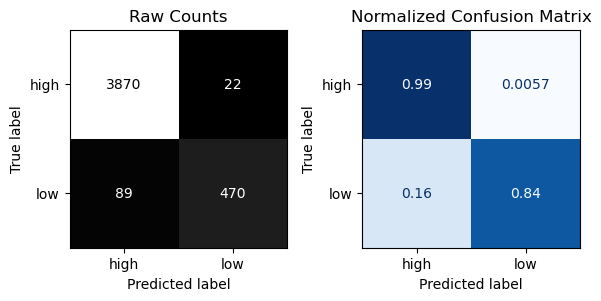


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.96      0.99      0.97      1157
         low       0.89      0.70      0.79       178

    accuracy                           0.95      1335
   macro avg       0.92      0.84      0.88      1335
weighted avg       0.95      0.95      0.95      1335



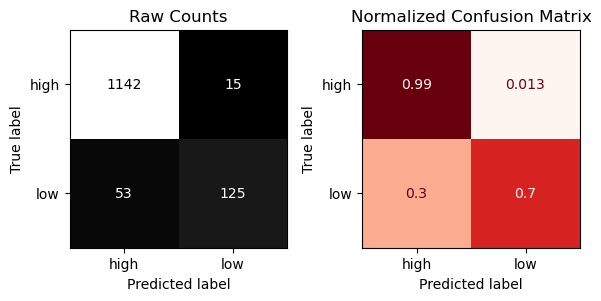

In [38]:
evaluate_classification(count_pipe, X_train, y_train, X_val, y_val)

Our model was 95% accurate, but did not seem overly biased against any given class.  There might be a slight bias toward the neutral class.

## TF-IDF Vectorization

Another popular **Bag of Words** vectorization strategy is TF-IDF vectorization.  In this stragegy, rather than just counting each word, we compare the frequency of a word in a document with the frequency of that word in other documents.  This measures the specificity of the word.

If a word is common in a document, but rare in the corpus as a whole, it gets a higher value.  If it's common throughout the corpus, it gets a lower value.  This helps TF-IDF vectorized data to resist the effects of common stop words or other words that tend to be common in that particular corpus.  They will have a lesser effect on the prediction.

[TfidfVectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [39]:
## Instantiate TF-IDF Vectorizor
tfidf = TfidfVectorizer()#min_df=3, ngram_range=(1,2))

tfidfbayes = MultinomialNB()

tfidf_pipe = Pipeline([('tfidfvectorizer', tfidf),
                       ('bayes_model', tfidfbayes)])

tfidf_pipe.fit(X_train, y_train)

                      

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('bayes_model', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.88      1.00      0.94      3892
         low       1.00      0.04      0.08       559

    accuracy                           0.88      4451
   macro avg       0.94      0.52      0.51      4451
weighted avg       0.89      0.88      0.83      4451



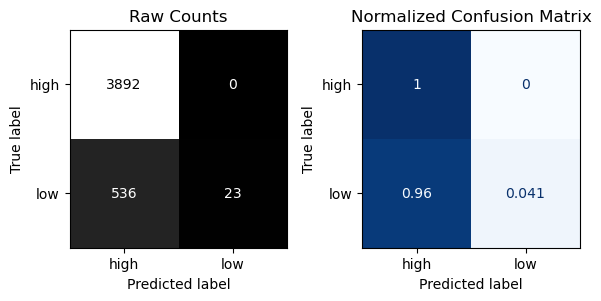


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.87      1.00      0.93      1157
         low       1.00      0.01      0.01       178

    accuracy                           0.87      1335
   macro avg       0.93      0.50      0.47      1335
weighted avg       0.89      0.87      0.81      1335



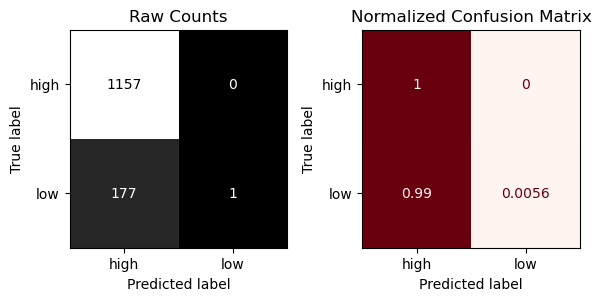

In [40]:
evaluate_classification(tfidf_pipe, X_train, y_train, X_val, y_val)

In this case we are seeing a stronger model bias toward the neutral class and an overall reduction in model accuracy.  The CountVectorizer seems to have been the better choice.

# Conclusion

There are a lot of choices in how to prepare data for text classification:
* Remove stop words and punctuation?
* Lemmatize?  Stem?
* How to Vectorize?
* ngrams?

## Challenge:

Try improving the score.  Ideas to try:
* Try a different version of the data: non-lemmatized data, include stop words, different range of n_grams
* Tune the vectorizer: Increase the min_df, decrease the max_df, other options: [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* Tune the model: [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
* Try a different model: Can use any classification model for this.
* Consider PCA
* Be sure to evaluate each of your models only on the X_val/y_val
* Evaluate your best model on the holdout X_test/y_test

# GridSearch Text Preprocessing Params

In [41]:
gs_pipe = Pipeline([('vectorizer',CountVectorizer()),
                    ('clf',MultinomialNB())])
gs_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()), ('clf', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'clf__force_alpha': 'warn'}

In [42]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_combined = [param_grid_count, param_grid_tfidf]
params_combined

[{'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'vectorizer': [TfidfVectorizer()],
  'vectorizer__norm': ['l1', 'l2'],
  'vectorizer__use_idf': [True, False],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']}]

In [43]:
%%time
# Create grid search
grid_search = GridSearchCV(gs_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits
CPU times: user 3.12 s, sys: 1.56 s, total: 4.68 s
Wall time: 13.7 s


{'vectorizer': CountVectorizer(max_df=0.8, min_df=4),
 'vectorizer__max_df': 0.8,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 4,
 'vectorizer__stop_words': None}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.98      0.99      0.98      3892
         low       0.90      0.87      0.88       559

    accuracy                           0.97      4451
   macro avg       0.94      0.93      0.93      4451
weighted avg       0.97      0.97      0.97      4451



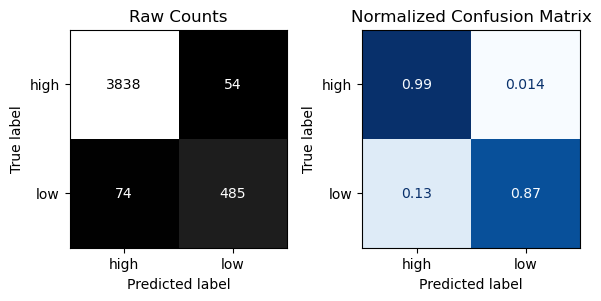


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.96      0.98      0.97       498
         low       0.85      0.76      0.80        75

    accuracy                           0.95       573
   macro avg       0.91      0.87      0.89       573
weighted avg       0.95      0.95      0.95       573



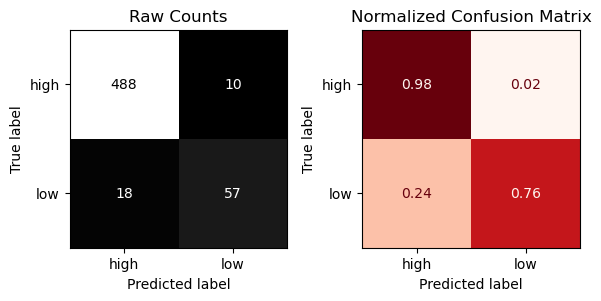

In [44]:
best_gs_pipe = grid_search.best_estimator_
evaluate_classification(best_gs_pipe, X_train, y_train, X_test, y_test)

### RandomForest

In [45]:
rf_pipe  = Pipeline([('vectorizer',CountVectorizer()),
                    ('clf',RandomForestClassifier(class_weight='balanced'))])
rf_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('clf', RandomForestClassifier(class_weight='balanced'))],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': RandomForestClassifier(class_weight='balanced'),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__bootstrap': True,
 'clf__ccp_alpha': 0.0,
 'clf__class_weight': 'balanced',
 'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': 'sqrt',
 'clf__max_leaf_node

In [46]:
%%time
# Create grid search
grid_search = GridSearchCV(rf_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits
CPU times: user 3.9 s, sys: 1.53 s, total: 5.42 s
Wall time: 51.6 s


{'vectorizer': TfidfVectorizer(max_df=0.9, max_features=1000, min_df=3, stop_words='english'),
 'vectorizer__max_df': 0.9,
 'vectorizer__max_features': 1000,
 'vectorizer__min_df': 3,
 'vectorizer__norm': 'l2',
 'vectorizer__stop_words': 'english',
 'vectorizer__use_idf': True}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       1.00      1.00      1.00      3892
         low       0.99      1.00      1.00       559

    accuracy                           1.00      4451
   macro avg       1.00      1.00      1.00      4451
weighted avg       1.00      1.00      1.00      4451



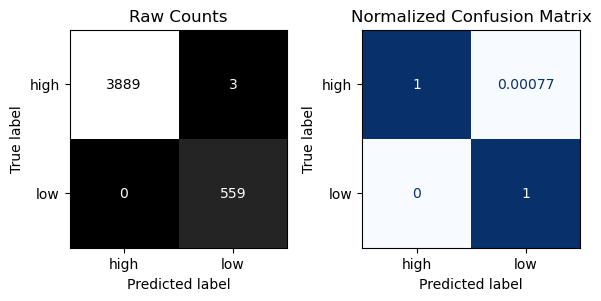


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.93      1.00      0.96       498
         low       0.95      0.52      0.67        75

    accuracy                           0.93       573
   macro avg       0.94      0.76      0.82       573
weighted avg       0.93      0.93      0.93       573



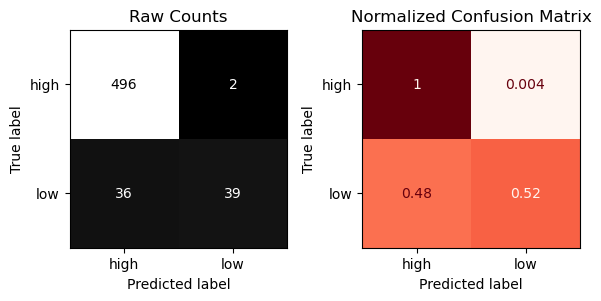

In [47]:
best_rf_pipe = grid_search.best_estimator_
evaluate_classification(best_rf_pipe, X_train, y_train, X_test, y_test)

### LogReg

In [48]:
logreg_pipe  = Pipeline([('vectorizer',CountVectorizer()),
                    ('clf',LogisticRegression(max_iter=500, class_weight='balanced'))])
# logreg_pipe.get_params()

In [49]:
%%time
# Create grid search
grid_search = GridSearchCV(logreg_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits
CPU times: user 2.04 s, sys: 767 ms, total: 2.81 s
Wall time: 14.2 s


{'vectorizer': CountVectorizer(max_df=0.8, min_df=2),
 'vectorizer__max_df': 0.8,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 2,
 'vectorizer__stop_words': None}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       1.00      1.00      1.00      3892
         low       0.99      1.00      1.00       559

    accuracy                           1.00      4451
   macro avg       1.00      1.00      1.00      4451
weighted avg       1.00      1.00      1.00      4451



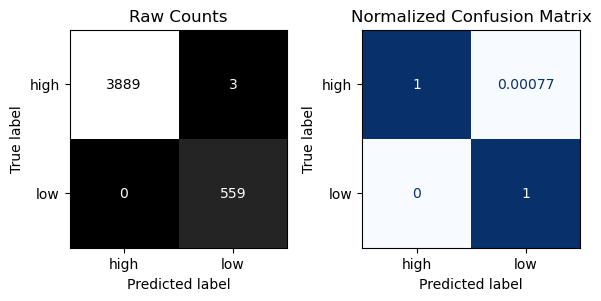


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.98      0.96      0.97       498
         low       0.78      0.87      0.82        75

    accuracy                           0.95       573
   macro avg       0.88      0.92      0.90       573
weighted avg       0.95      0.95      0.95       573



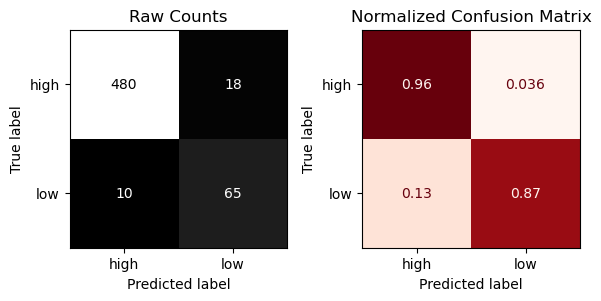

In [50]:
best_logreg_pipe = grid_search.best_estimator_
evaluate_classification(best_logreg_pipe, X_train, y_train, X_test, y_test)